<a href="https://colab.research.google.com/github/muhajirakbarhsb/NLP_class_2023/blob/main/Week_Class_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install emoji
!pip install Sastrawi

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: celery 5.0.5 has a non-standard dependency specifier pytz>dev. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import re
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
df = pd.read_csv('data_clean_all.csv')
df

,at,content,score,userName,contentp,contentp_clean,text_length
0,2023-09-21 14:31:30,Sering muncul peringatan 'anda tidak terhubung...,5,Wilson Nts,sering muncul peringatan anda tidak terhubung ...,sering muncul ingat tidak hubung jaring orbit ...,238
1,2023-09-28 00:14:40,"Masih sering DC. Tiba2 g ada koneksi, lampu in...",1,Saifullah fil,masih sering dc tiba ada koneksi lampu indokat...,sering dc tiba koneksi lampu indokator merah e...,226
2,2023-09-24 13:44:07,Bapuk. Lemot. Padahal sudah di Taru dekat jend...,1,allan afriyadi,bapuk lemot padahal sudah di taru dekat jendel...,jelek lambat padahal taru dekat jendela lantai...,269
3,2023-09-18 21:58:35,"Sering muncul tulisan ""tidak terhubung ke .......",3,Suryokusumo Risdika Rizki,sering muncul tulisan tidak terhubung ke nama ...,sering muncul tulis hubung nama wifi padahal j...,240
4,2023-10-02 21:40:00,Sudah beli model yg harganya sampai 2 jutaan. ...,3,Anton Karnadi,sudah beli model yg harganya sampai jutaan awa...,beli model harga juta awal kencang tahun pakai...,147
...,...,...,...,...,...,...,...
3017,2023-02-06 16:52:51,Good,4,Prinstony Bella,good,good,4
3018,2023-05-01 18:30:41,Semngat,4,Agus Adekaputra,semngat,semngat,7
3019,2023-01-18 22:03:06,🙏🙏🙏🙏,5,Meki Mote,NaN,NaN,0
3020,2023-04-02 18:06:26,👍👍👍👍,5,Bertus Soen,NaN,NaN,0


In [4]:
df['sentiment'] = df['score'].apply(lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive'))

In [5]:
df = df[['contentp_clean',  'sentiment']]
df = df.dropna()
df.head(3)

,contentp_clean,sentiment
0,sering muncul ingat tidak hubung jaring orbit ...,positive
1,sering dc tiba koneksi lampu indokator merah e...,negative
2,jelek lambat padahal taru dekat jendela lantai...,negative


In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment"])
np.save('bert_classes.npy', label_encoder.classes_)

In [7]:
df

,contentp_clean,sentiment,label
0,sering muncul ingat tidak hubung jaring orbit ...,positive,2
1,sering dc tiba koneksi lampu indokator merah e...,negative,0
2,jelek lambat padahal taru dekat jendela lantai...,negative,0
3,sering muncul tulis hubung nama wifi padahal j...,neutral,1
4,beli model harga juta awal kencang tahun pakai...,neutral,1
...,...,...,...
3014,lelettt,neutral,1
3016,oke,positive,2
3017,good,positive,2
3018,semngat,positive,2


In [8]:
PRE_TRAINED_MODEL_NAME = 'indobenchmark/indobert-base-p2'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
df_clean = df[['contentp_clean', 'label']]

In [10]:
token_lens = []

for txt in df_clean.contentp_clean:
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_lens.append(len(tokens))

C:\Users\Alharidt\AppData\Local\Temp\ipykernel_4684\1971794795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


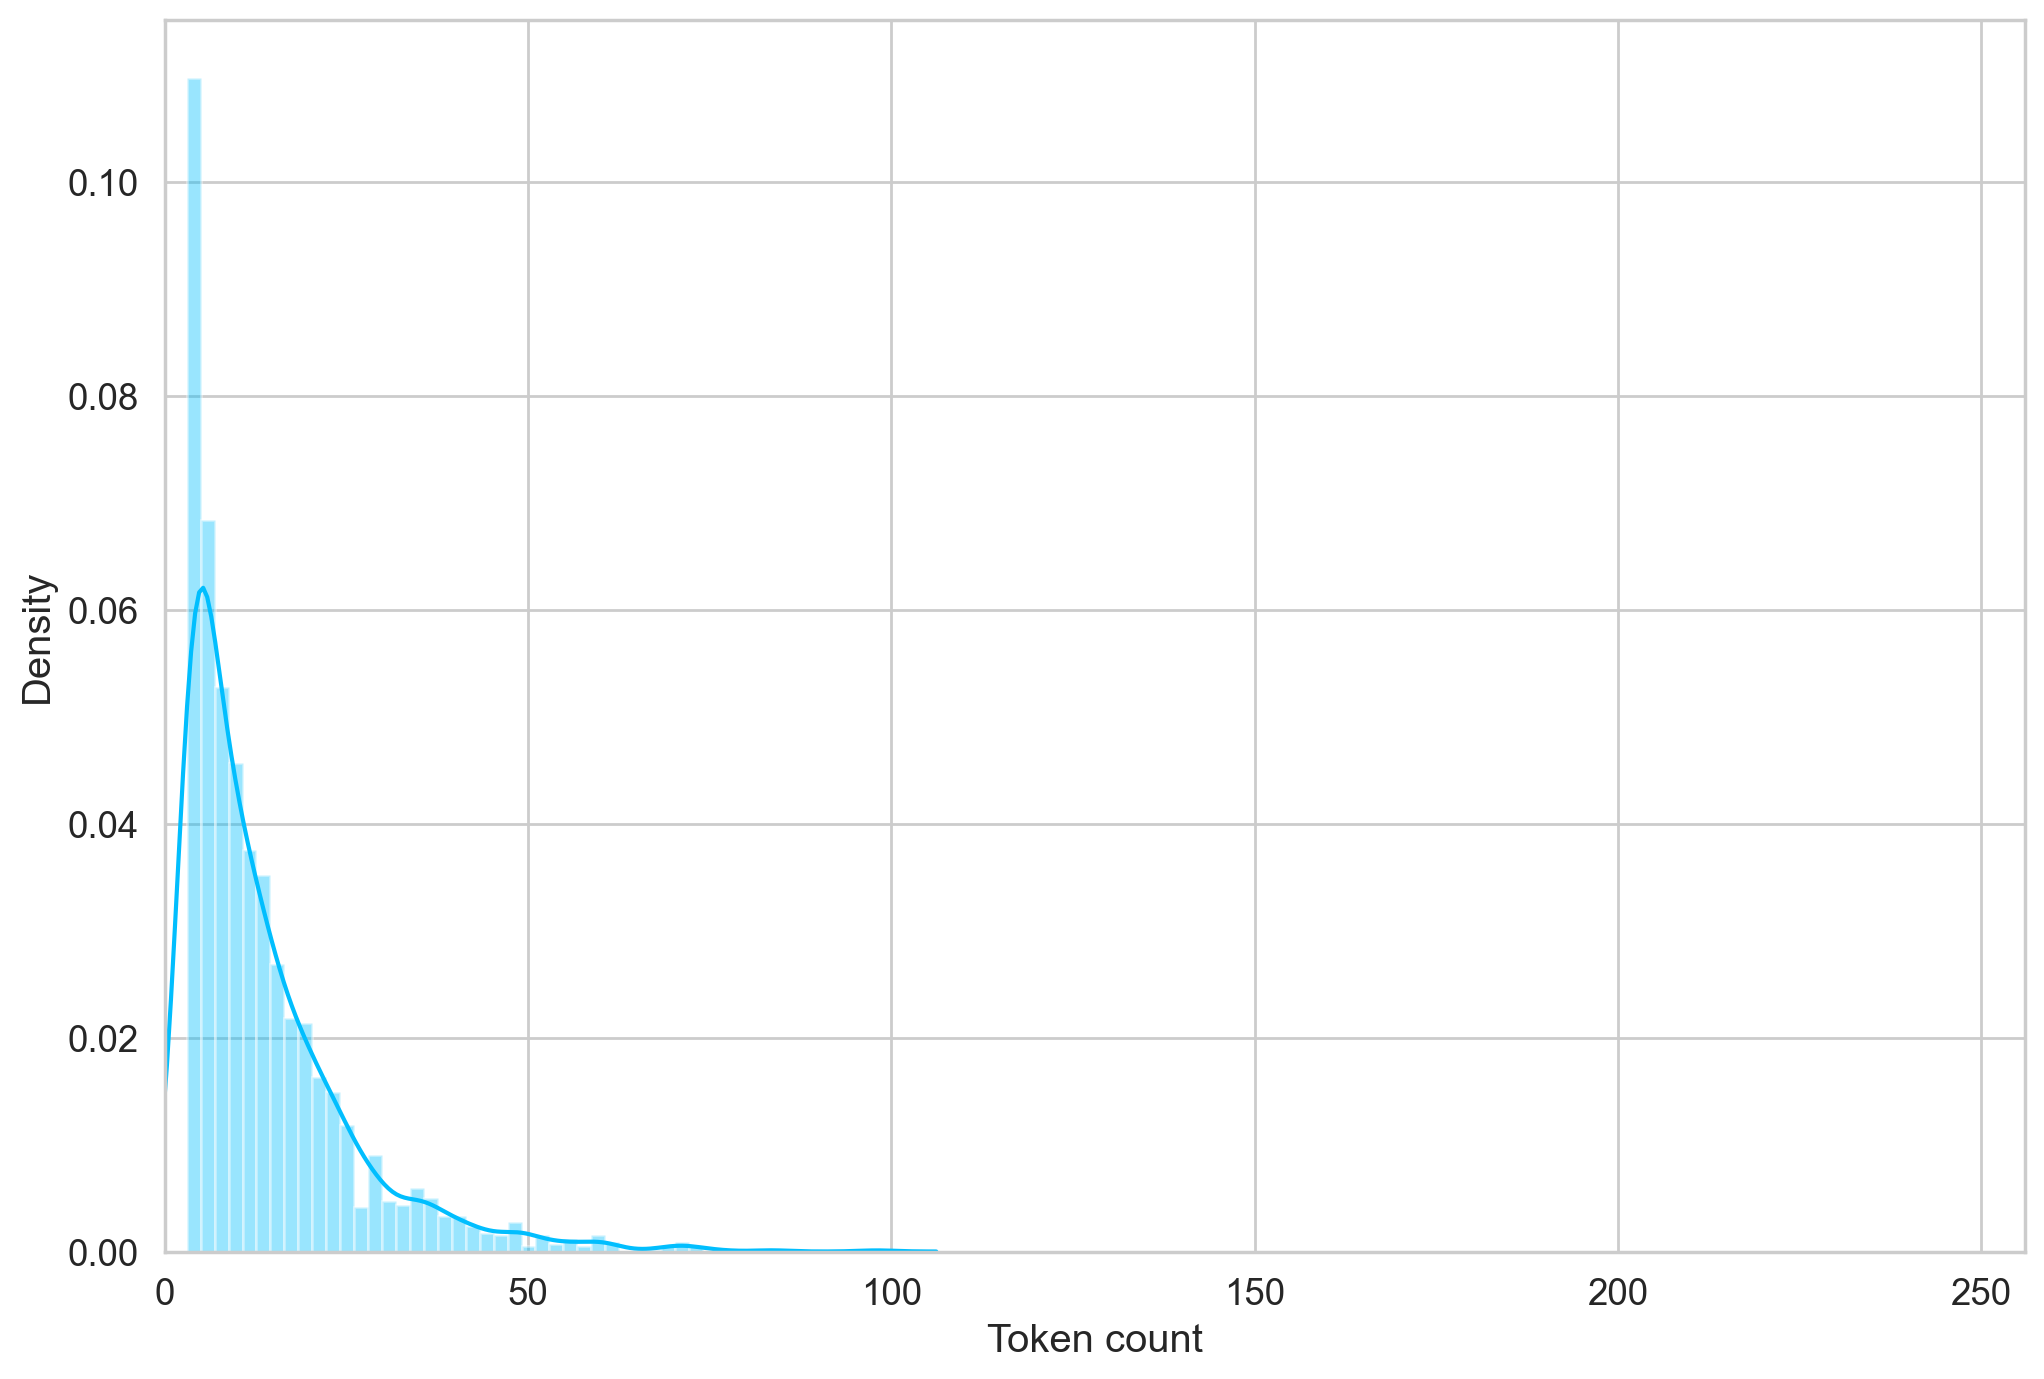

In [11]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [12]:
MAX_LEN = 60

In [13]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [14]:
df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [15]:
df_val["label"].value_counts()

0    170
2    105
1     25
Name: label, dtype: int64

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.contentp_clean.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [17]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

C:\Users\Alharidt\AppData\Roaming\Python\Python311\site-packages\torch\utils\data\dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
df

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)


  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output[1])
    return self.out(output)

In [ ]:
model = SentimentClassifier(3)
model = model.to(device)

In [ ]:
EPOCHS = 10
# Learning Rate
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'bert_symptoms.bin')
    best_accuracy = val_acc

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
ypred = label_encoder.inverse_transform(y_pred)
ytest = label_encoder.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
cm = confusion_matrix(ytest, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = label_encoder.classes_)
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,20)
disp.plot()
plt.show()

In [ ]:
print(classification_report(ytest, ypred))

##predict

In [ ]:
def predict(teks):
      review_baru = [str(teks)]
      df = pd.DataFrame(review_baru, columns=["contentp_clean"])
      return df

df = predict("Aplikasi lag banget, loading terus")

In [ ]:
df

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    reviews=df.contentp_clean.to_numpy(),
    # targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )



def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
          # targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
          # real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    # real_values = torch.stack(real_values).cpu()
    # return review_texts, predictions, prediction_probs, real_values
    return review_texts, predictions, prediction_probs

class GPReviewDataset(Dataset):

    def __init__(self, reviews, tokenizer, max_len):
    # def __init__(self, reviews, targets, tokenizer, max_len):
          self.reviews = reviews
      # self.targets = targets
          self.tokenizer = tokenizer
          self.max_len = max_len

    def __len__(self):
          return len(self.reviews)

    def __getitem__(self, item):
          review = str(self.reviews[item])
      # target = self.targets[item]

          encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
          )

          return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            # 'targets': torch.tensor(target, dtype=torch.long)
          }

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output[1])
        return self.out(output)




def predict(teks):
      review_baru = [str(teks)]
      df = pd.DataFrame(review_baru, columns=["contentp_clean"])
      return df


if __name__ == "__main__":
        df = predict("Aplikasi lag banget, loading terus")
        #df = df[['tanggal', 'bundle', 'label', 'is_sentiment', 'contentp_clean']]
        encoder = LabelEncoder()
        encoder.classes_ = np.load('bert_classes.npy', allow_pickle=True)
        model = SentimentClassifier(3)
        model.load_state_dict(torch.load('bert_symptoms.bin',  map_location=torch.device('cpu')))
        model = model.to(device)
        testing_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
        y_review_texts, y_pred, y_pred_probs = get_predictions(
          model,
          testing_data_loader
        )
        ypred = encoder.inverse_transform(y_pred)
        df["Topic_category"] = ypred






In [ ]:
df

In [ ]:
if __name__ == "__main__":
        df = predict("harga murah internet kencang")
        #df = df[['tanggal', 'bundle', 'label', 'is_sentiment', 'contentp_clean']]
        encoder = LabelEncoder()
        encoder.classes_ = np.load('bert_classes.npy', allow_pickle=True)
        model = SentimentClassifier(3)
        model.load_state_dict(torch.load('bert_symptoms.bin',  map_location=torch.device('cpu')))
        model = model.to(device)
        testing_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)
        y_review_texts, y_pred, y_pred_probs = get_predictions(
          model,
          testing_data_loader
        )
        ypred = encoder.inverse_transform(y_pred)
        df["Topic_category"] = ypred
        print(df)
